<a href="https://colab.research.google.com/github/mjdall/pinterest_scraper/blob/master/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
efficient net paper - https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html
efficient net fine tuning - https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
efficient net implementation - https://github.com/qubvel/efficientnet
transfer learning example - https://www.tensorflow.org/tutorials/images/transfer_learning
classification head - https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
image embeddings - https://rom1504.medium.com/image-embeddings-ed1b194d113e
  https://github.com/rom1504/image_embeddings/blob/master/notebooks/using_the_lib.ipynb
  https://github.com/rom1504/image_embeddings/blob/master/notebooks/from_scratch.ipynb

"""

'\nefficient net paper - https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html\nefficient net fine tuning - https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/\nefficient net implementation - https://github.com/qubvel/efficientnet\ntransfer learning example - https://www.tensorflow.org/tutorials/images/transfer_learning\nclassification head - https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/\nimage embeddings - https://rom1504.medium.com/image-embeddings-ed1b194d113e\n  https://github.com/rom1504/image_embeddings/blob/master/notebooks/using_the_lib.ipynb\n  https://github.com/rom1504/image_embeddings/blob/master/notebooks/from_scratch.ipynb\n\n'

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os

os.chdir("/content/drive/MyDrive/pinterest_scraper/")

In [ ]:
import pandas as pd

image_locs = pd.read_csv("data/image_reference.csv")
image_locs.sample(5)

,Unnamed: 0,label,file_location,group_id
2429,2429,Interior design,data/interior_design/dd2bf83087a726ab0688bff58...,222
3692,3692,Modern farmhouse kitchens,data/modern_farmhouse_kitchens/417a110ef58acfc...,485
5171,5171,Tattoo sketches,data/tattoo_sketches/4b6b666ff14a0b0c38b627a94...,472
1265,1265,Food porn,data/food_porn/3eccb03a6be2b74d16b9e6489deadf8...,58
1264,1264,Food porn,data/food_porn/48903a8dca2da9d44b933ae71830b3e...,57


In [ ]:
def get_group(group_id, training_ids, testing_ids):
  if group_id in training_ids:
    return("training")
  elif group_id in testing_ids:
    return("testing")
  else:
    return("validation")

In [ ]:
import math
import numpy as np

TRAINING_SIZE = .7

available_labels = image_locs.label.unique().tolist()

for label in available_labels:
  label_subset = image_locs[image_locs.label == label]
  group_ids = label_subset.group_id.reset_index(drop=True)

  # get train/test/validation ids
  training_ids = group_ids.sample(frac=TRAINING_SIZE)
  remaining_ids = group_ids[~group_ids.isin(training_ids)]
  testing_ids = remaining_ids.sample(frac=.5)

  # make a lambda to apply
  alloc_lmbda = lambda gid: get_group(gid, training_ids, testing_ids)

  # write the split allocation to the df
  image_locs.loc[label_subset.index, "split"] = label_subset.group_id.apply(alloc_lmbda)

image_locs

,Unnamed: 0,label,file_location,group_id,split
0,0,90s fashion men,data/90s_fashion_men/cfaf965d69f685d8e69956ba7...,0,training
1,1,90s fashion men,data/90s_fashion_men/fa6f7f62186191520d17ec3df...,1,training
2,2,90s fashion men,data/90s_fashion_men/d9cb8bce7608cf99e01f24c98...,2,training
3,3,90s fashion men,data/90s_fashion_men/680414f948622b0203c1b0056...,3,training
4,4,90s fashion men,data/90s_fashion_men/f0cba34dd73764ef7b9962527...,4,training
...,...,...,...,...,...
5694,5694,White aesthetic,data/white_aesthetic/448946d180a5f9d9df8cbcf76...,495,testing
5695,5695,White aesthetic,data/white_aesthetic/ea64d4023642884c808f6c7e7...,496,training
5696,5696,White aesthetic,data/white_aesthetic/79b0856002598d613564b80eb...,497,validation
5697,5697,White aesthetic,data/white_aesthetic/7f2ec49fdd6c5928ddad23a87...,498,training


In [ ]:
image_locs.groupby("label").split.value_counts()

label                      split     
90s fashion men            training      145
                           testing        31
                           validation     31
Bullet journal             training      350
                           testing        75
                           validation     75
Easy drawings              training      350
                           testing        75
                           validation     75
Food porn                  training      350
                           testing        75
                           validation     75
Forearm tattoos            training      350
                           testing        75
                           validation     75
Interior design            training      350
                           testing        75
                           validation     75
Mens clothing styles       training      350
                           testing        75
                           validation     75
Modern farmhouse 

In [ ]:
import pathlib
import shutil
import re

def get_save_directory_name(label):
  return(re.sub(r"\s+", "_" , label.lower()))

get_file_directory = lambda file_location: str(pathlib.Path(file_location).parent) + "/"

def partition_data(image_locations):
  # get the label directory name
  image_locations["label_dir"] = image_locations.label.apply(
      get_save_directory_name)
  image_locations["filename"] = image_locations.file_location.apply(
      os.path.basename)
  label_dirs = image_locations.label_dir.unique()

  # remove current allocation of images and re-create the data directories
  data_splits = image_locations.split.unique().tolist()
  for split in data_splits:
    split_dir = f"data/{split}"
    if os.path.exists(split_dir):
      shutil.rmtree(split_dir)
    for label_dir in label_dirs:
      os.makedirs(f"{split_dir}/{label_dir}", exist_ok=True)


  # get the new path of the image
  image_locations["new_location"] = ("data/"
    + image_locations.split
    + "/"
    + image_locations.label_dir
    + "/"
    + image_locations.filename)

  # copy the image into the new directory
  for _, image_row in image_locations.iterrows():
    # todo: add progress bar here
    shutil.copy2(image_row.file_location, image_row.new_location)

# partition_data(image_locs)
# image_locs.to_csv("data/image_partitions.csv")

In [ ]:
IMG_SIZE = 224
SIZE = (IMG_SIZE, IMG_SIZE)
BATCH_SIZE = 64
DATASET_NAME = "pinterest"
NUM_CLASSES = image_locs.label.nunique()

In [33]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# load in the datasets
train_ds = image_dataset_from_directory("data/training", label_mode="categorical")
test_ds = image_dataset_from_directory("data/testing", label_mode="categorical")
validation_ds = image_dataset_from_directory("data/validation", label_mode="categorical")

train_ds

Found 3989 files belonging to 12 classes.
Found 855 files belonging to 12 classes.
Found 855 files belonging to 12 classes.


<BatchDataset shapes: ((None, 256, 256, 3), (None, 12)), types: (tf.float32, tf.float32)>

In [34]:
import tensorflow as tf
resize_lambda = lambda image, label: (tf.image.resize(image, SIZE), label)

def preprocess_dataset(dataset, batch_size=BATCH_SIZE):
  dataset = dataset.map(resize_lambda)
  # dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  return(dataset)

train_ds = preprocess_dataset(train_ds)
test_ds = preprocess_dataset(test_ds)
validation_ds = preprocess_dataset(validation_ds)

In [35]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

InvalidArgumentError: ignored

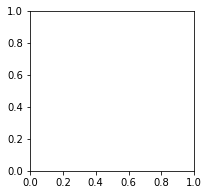

In [36]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory

for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))

  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    augmented_image = img_augmentation(first_image)
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [38]:
from tensorflow.keras.applications import EfficientNetB0

IMG_SHAPE = SIZE + (3,)

base_model = tf.keras.applications.EfficientNetB0(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights="imagenet")
base_model.trainable = False

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)

print(feature_batch.shape)

(32, 7, 7, 1280)


In [39]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

print(feature_batch_average.shape)

(32, 1280)


In [40]:
prediction_layer = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)

print(prediction_batch.shape)

(32, 12)


In [41]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

In [42]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = img_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [45]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

len(model.trainable_variables)

2

In [46]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_ds)


27/27 [==============================] - 170s 4s/step - loss: 2.6391 - accuracy: 0.0519


In [47]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.63
initial accuracy: 0.05


In [48]:
history = model.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=validation_ds)

Epoch 1/10
125/125 [==============================] - 361s 3s/step - loss: 2.2928 - accuracy: 0.2091 - val_loss: 1.9356 - val_accuracy: 0.4140
Epoch 2/10
125/125 [==============================] - 352s 3s/step - loss: 1.7614 - accuracy: 0.4811 - val_loss: 1.5208 - val_accuracy: 0.5906
Epoch 3/10
125/125 [==============================] - 352s 3s/step - loss: 1.4333 - accuracy: 0.6064 - val_loss: 1.2672 - val_accuracy: 0.6561
Epoch 4/10
125/125 [==============================] - 352s 3s/step - loss: 1.2291 - accuracy: 0.6596 - val_loss: 1.1105 - val_accuracy: 0.7018
Epoch 5/10
125/125 [==============================] - 347s 3s/step - loss: 1.1021 - accuracy: 0.6799 - val_loss: 1.0053 - val_accuracy: 0.7228
Epoch 6/10
125/125 [==============================] - 348s 3s/step - loss: 1.0096 - accuracy: 0.7002 - val_loss: 0.9331 - val_accuracy: 0.7263
Epoch 7/10
125/125 [==============================] - 349s 3s/step - loss: 0.9364 - accuracy: 0.7190 - val_loss: 0.8801 - val_accuracy: 0.7333

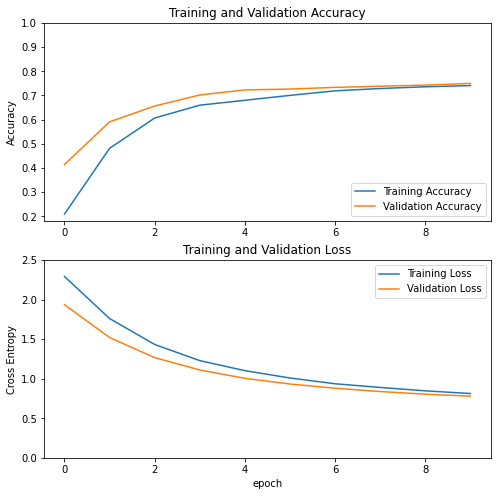

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 2.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [53]:
# save the model
model.save("model")

INFO:tensorflow:Assets written to: model/assets
